In [11]:
import numpy as np
import pandas as pd 
%pylab inline
import matplotlib.pyplot as plt
# 华泰获利分布研究

Populating the interactive namespace from numpy and matplotlib


In [115]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Jan  1 10:25:16 2020
分析获利情况  华泰账户
@author: quchaodong
"""

#import numpy as np
import pandas as pd 
import datetime

#import matplotlib.pyplot as plt


class StockProfile:
    code=''
    name=''
    start_buy_date=''
    end_date=''
    max_pay=0
    
    buy = 0;
    vol_hold = 0;
    days = 0;
    
    def __init__(self, code , name ):
        self.code = code
        self.name = name
        self.start_buy_date = ''
        self.end_date = ''
        self.name = name
        self.buy = 0;
        self.vol_hold = 0;
        self.days = 0;
        

    def info(self ):
        d1 = datetime.datetime.strptime(self.start_buy_date, '%Y%m%d')
        d2 = datetime.datetime.strptime(self.end_date, '%Y%m%d')
        self.days = (d2 - d1).days



        print( '\t',self.code , 
              '\t' ,self.name , 
              '\t' ,self.start_buy_date,
              '\t' ,self.end_date,
              '\t' , self.buy,
              '\t' ,self.days,
              '');
    
    def OnHandle(self , row):
        flag = row['flag']
        money = row['money']        
        vol = row['vol']  
        #print (str(row['date1'] ))
        if(self.buy == 0 ):
            self.start_buy_date = str(row['date1'])
        
        if( flag.find('证券买入') == 0 ):
            self.buy = self.buy - money
            self.vol_hold = self.vol_hold + vol
            #print(self.vol_hold , ' \t buy ' , vol)
        elif(  flag.find('证券卖出') == 0  ):
            self.buy = self.buy + money
            # 注意 华泰导出数据，卖出vol 用负数表示
            self.vol_hold =self.vol_hold + vol
            #print(self.vol_hold , ' \t sell ' , vol)
        else :
            return 0
            
        if self.vol_hold ==0 :
            # 本次利润计算结束
            #print ('after saled out, earn :\t',  self.buy );
            #self.buy = 0;
            #self.vol_hold = 0;   
            #print ('start new ' )
            self.end_date= str(row['date1'])
            return 1 
        
        elif self.vol_hold < 0 :
            # erro data
            print ('can not caculate  ' , self.code)
            self.buy = 0;
            self.vol_hold = 0;    
        
        return 0;


def getCodeData( oneCodeData):
    a1 = oneCodeData.sort_values(['date1','num'])
    return a1

allProfiles = [];
# 计算收益
def cacCodeRet( code, codeDetail ):
    
    _name = codeDetail['name'].iloc[0]
    sp = StockProfile(code , _name );
   
    
    for index, row in codeDetail.iterrows():
        ret = sp.OnHandle(row)
        if( 1 == ret ):
            #print('----');
            allProfiles.append(sp)
            
            # 新建对象
            sp = StockProfile(code , _name);
            
        
    return ;


def stand_data( fileName):
    #exlc转化后格式读取
    data = pd.read_excel(fileName )    
    colMap =  {
                "成交日期": "date1",        
                "证券代码": "code",
                "证券名称":"name",
                "操作":"flag",
                 "成交均价":"price",
                "成交数量":"vol",
                "成交金额":"money",
                "合同编号":"num"}


    dt = data.rename(columns=colMap  ) 
    usedCol = list(colMap.values())
    
    return dt[usedCol]


def stand_raw_data( fileName):
    #华泰导出数据，原始数据
    col_zh =[
            "成交日期",        
            "证券代码",
            "证券名称",
            "操作",
             "成交均价",
            "成交数量",
            "成交金额",
            "合同编号"
            ]

    x = pd.read_csv( fileName,                   
                    sep='\t',usecols=col_zh, 
                    encoding='gbk')
    
    colMap =  {
            "成交日期": "date1",        
            "证券代码": "code",
            "证券名称":"name",
            "操作":"flag",
             "成交均价":"price",
            "成交数量":"vol",
            "成交金额":"money",
            "合同编号":"num"}


    dt = x.rename(columns=colMap  ) 
    
    return dt[ (dt.flag=='证券卖出') | (dt.flag=='证券买入')]

def wash_org_data( fileName  ) :
    #dt = stand_data( fileName)
    dt = stand_raw_data( fileName)
    g= dt.groupby('code')

    return  g;

#多个文件
def wash_multi_org_data( files  ) :
    #dt = stand_data( fileName)
    index =0;
    dt ={}

    for fileName in files:     
        print(fileName)
        index = index + 1 
        if index == 1 :
            dt = stand_raw_data( fileName)
        else:            
            dt1 = stand_raw_data( fileName)
            dt = dt.append(dt1)
            
    
    g= dt.groupby('code')

    return  g;


def ana_single_file( fileName):
    
    allProfiles.clear();
    
    g= wash_org_data(fileName)


    #计算每个股票/每次 收益 
    for name, group in g:
        x = getCodeData ( group)
        #print(x)
        cacCodeRet(name , x)
        
    
    print('')
    
    for s in allProfiles:
        #print(s)
        s.info()
  
    
    return

def ana_mult_file( files):
    allProfiles.clear()
    
    g= wash_multi_org_data(files)


    #计算每个股票/每次 收益 
    for name, group in g:
        x = getCodeData ( group)
        #print(x)
        cacCodeRet(name , x)
        
    
    print('')
    
    for s in allProfiles:
        #print(s)
        s.info()
  
    
    return

    

In [116]:
print("---- multi files ")
'''
files = { '/Users/quchaodong/stu/py_research/tmp/ht/his_ht1910.xls' ,
          '/Users/quchaodong/stu/py_research/tmp/ht/his_ht1911.xls',
          '/Users/quchaodong/stu/py_research/tmp/ht/his_ht1912.xls',
          '/Users/quchaodong/stu/py_research/tmp/ht/his_ht2001.xls',
          '/Users/quchaodong/stu/py_research/tmp/ht/his_ht2002.xls',
         }
'''
files =[]
for i in range(1,13):
    files.append( '/Users/quchaodong/stu/py_research/tmp/ht/his_ht19' +"{:0>2d}".format(i)+'.xls' )
for i in range(1,3):
    files.append( '/Users/quchaodong/stu/py_research/tmp/ht/his_ht20' +"{:0>2d}".format(i)+'.xls' )
 

ana_mult_file(files)

---- multi files 
/Users/quchaodong/stu/py_research/tmp/ht/his_ht1901.xls
/Users/quchaodong/stu/py_research/tmp/ht/his_ht1902.xls
/Users/quchaodong/stu/py_research/tmp/ht/his_ht1903.xls
/Users/quchaodong/stu/py_research/tmp/ht/his_ht1904.xls
/Users/quchaodong/stu/py_research/tmp/ht/his_ht1905.xls
/Users/quchaodong/stu/py_research/tmp/ht/his_ht1906.xls
/Users/quchaodong/stu/py_research/tmp/ht/his_ht1907.xls
/Users/quchaodong/stu/py_research/tmp/ht/his_ht1908.xls
/Users/quchaodong/stu/py_research/tmp/ht/his_ht1909.xls
/Users/quchaodong/stu/py_research/tmp/ht/his_ht1910.xls
/Users/quchaodong/stu/py_research/tmp/ht/his_ht1911.xls
/Users/quchaodong/stu/py_research/tmp/ht/his_ht1912.xls
/Users/quchaodong/stu/py_research/tmp/ht/his_ht2001.xls
/Users/quchaodong/stu/py_research/tmp/ht/his_ht2002.xls
can not caculate   2241
can not caculate   2241
can not caculate   2241
can not caculate   2241
can not caculate   300433
can not caculate   300433
can not caculate   600038
can not caculate   60011

In [117]:
#for name, group in all_group_data :
    #print(name)
all_group_data.get_group(1)

,date1,name,flag,vol,price,money
15,20190905,平安银行,证券买入,900,14.76,13284.0
22,20190906,平安银行,证券买入,1100,14.67,16137.0
35,20190911,平安银行,证券卖出,-1000,14.53,14530.0
38,20190916,平安银行,证券买入,1000,14.54,14540.0
43,20190917,平安银行,证券卖出,-1500,14.22,21330.0
48,20190919,平安银行,证券卖出,-500,14.75,7375.0


In [118]:
#按照日期，计算获利信息
earnsCode=[]
for s in allProfiles:
    m = str(s.start_buy_date)
    #print(m[0:4])
    a = {'code':s.name +str( s.code), 'earn':s.buy , 
         'in_date':str(s.start_buy_date),
         'out_date':str(s.end_date),
         'in_month':m[0:6],
         'hold_days':s.days}
    earnsCode.append(a)
dt_earn = pd.DataFrame(earnsCode)
dt_a= dt_earn.sort_values('in_date').reset_index()

In [119]:
dt_a.head()

,index,code,earn,in_date,out_date,in_month,hold_days
0,65,国金证券600109,-48.0,20190107,20190108,201901,1
1,33,东方财富300059,44.0,20190125,20190128,201901,3
2,66,北方稀土600111,-8.0,20190125,20190125,201901,0
3,71,国电南瑞600406,124.0,20190125,20190128,201901,3
4,21,沪电股份2463,-156.0,20190129,20190130,201901,1


In [120]:
#统计正负次数
dt_a[dt_a['earn']>0].count()

index        66
code         66
earn         66
in_date      66
out_date     66
in_month     66
hold_days    66
dtype: int64

In [121]:
dt_a[dt_a['earn']<0].count()

index        22
code         22
earn         22
in_date      22
out_date     22
in_month     22
hold_days    22
dtype: int64

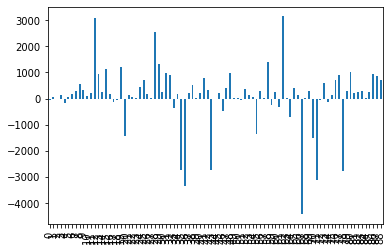

In [122]:
dt_a['earn'].plot.bar()

In [136]:
dt_a.groupby('in_month').size()

in_month
201901     5
201902    13
201903    21
201904     5
201905     2
201906     1
201907     2
201908    14
201909     9
201911     4
201912     3
202002    10
dtype: int64

In [137]:
#按照月份统计盈利/次数
m_ana = dt_a.groupby('in_month').agg({'earn': np.sum, 'in_date': np.size})

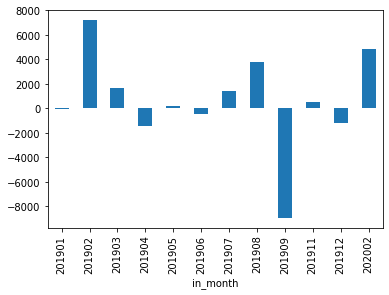

In [138]:
m_ana['earn'].plot.bar()

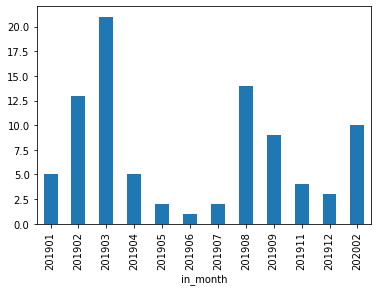

In [125]:
m_ana['in_date'].plot.bar()

In [139]:
m_ana

,earn,in_date
in_month,,
201901,-44.0,5
201902,7199.0,13
201903,1682.0,21
201904,-1409.0,5
201905,198.0,2
201906,-479.0,1
201907,1389.0,2
201908,3761.0,14
201909,-8940.0,9


In [ ]:
'''
总结： 
1.巨亏太大 19年9月 
2.4月亏损大，可能是 前几个月顺利，大意了
3.赚钱好像跟次数没有关系
4.胜率其实比较高
5.亏损持仓特征，持仓时间越长，亏损越大
6 亏损较大的次数大于 盈利较大次数（1000）
7 9月亏可能是因为8月做的较好. 
8. 亏损最大基本是科技股。
'''

In [131]:
# 分析巨大亏损
#all_group_data.get_group(2815)
dt_a[ dt_a['earn'] <-1000].sort_values('earn')

,index,code,earn,in_date,out_date,in_month,hold_days
67,19,广联达2410,-4430.0,20190906,20191029,201909,53
36,36,佳讯飞鸿300213,-3336.0,20190328,20190329,201903,1
71,28,崇达技术2815,-3126.0,20190920,20200204,201909,137
78,27,第一创业2797,-2790.0,20191224,20200204,201912,42
35,45,扬杰科技300373,-2748.0,20190321,20190326,201903,5
43,29,郑州银行2936,-2747.0,20190404,20190507,201904,33
70,51,宏达电子300726,-1527.0,20190920,20200204,201909,137
20,76,新钢股份600782,-1450.0,20190304,20190308,201903,4
55,42,硕贝德300322,-1356.0,20190827,20190830,201908,3


In [142]:
all_group_data.get_group(300373) 
#数据有问题

,date1,name,flag,vol,price,money
87,20190321,扬杰科技,证券买入,1100,20.080,22088.0
88,20190321,扬杰科技,证券买入,1000,19.840,19840.0
90,20190321,扬杰科技,证券买入,700,20.010,14007.0
93,20190322,扬杰科技,证券卖出,-1400,19.580,27412.0
97,20190325,扬杰科技,证券买入,700,19.090,13363.0
99,20190325,扬杰科技,证券卖出,-1400,18.851,26391.0
101,20190326,扬杰科技,证券卖出,-700,18.210,12747.0
123,20190401,扬杰科技,证券买入,400,19.250,7700.0
3,20190401,扬杰科技,证券买入,400,19.250,7700.0
11,20190402,扬杰科技,证券买入,800,19.730,15784.0


In [129]:
dt_a[ dt_a['earn'] >1000].sort_values('earn')

,index,code,earn,in_date,out_date,in_month,hold_days
15,82,潞安环能601699,1128.0,20190225,20190228,201902,3
19,37,科大智能300222,1212.0,20190304,20190307,201903,3
29,68,北方稀土600111,1332.0,20190315,20190318,201903,3
58,81,长城军工601606,1389.0,20190827,20190911,201908,15
28,69,中国卫星600118,2532.0,20190312,20190313,201903,1
12,79,中国人保601319,3100.0,20190222,20190226,201902,4
62,16,北方华创2371,3144.0,20190830,20190904,201908,5


In [141]:
dt_a[dt_a['in_month'] == '201909']

,index,code,earn,in_date,out_date,in_month,hold_days
63,48,温氏股份300498,24.0,20190904,20190905,201909,1
64,0,平安银行1,-726.0,20190905,20190919,201909,14
65,44,绿盟科技300369,390.0,20190905,20190910,201909,5
66,34,东方财富300059,150.0,20190906,20190911,201909,5
67,19,广联达2410,-4430.0,20190906,20191029,201909,53
68,5,顺络电子2138,27.0,20190919,20190920,201909,1
69,14,歌尔股份2241,278.0,20190919,20190920,201909,1
70,51,宏达电子300726,-1527.0,20190920,20200204,201909,137
71,28,崇达技术2815,-3126.0,20190920,20200204,201909,137
